In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'RL.csv'
fr = pd.read_csv(FILE)

In [14]:
Vin = np.array(fr['Vin']) # V
VR = np.array(fr['VR']) # V
VL = np.array(fr['VL']) # V
ν = np.array(fr['Freq (kHz)']) * 10**3# Hz 
ΦR = np.array(fr['faseR (deg)'], dtype=np.float64) * (np.pi / 180) # rad
ΦL = np.array(fr['faseL (deg)'], dtype=np.float64) * (np.pi / 180) # rad

sigma_Vin = 0.04
sigma_VR = np.array(fr['sigmaV_R'])
sigma_VL = np.array(fr['sigmaV_L'])

R = 9950 # ohm
sigmaR = R * 0.01 # errore associato ohmmetro
RL = 40
sigmaRL = RL * 0.01

sigma_ΦR = np.array(fr['sigmaF_R'], dtype=np.float64) * (np.pi/180.0) # rad
sigma_ΦL = np.array(fr['sigmaF_L'], dtype=np.float64) * (np.pi/180.0) # rad

## R
- $|H_R(\omega)| = \frac{R}{\sqrt{(R+R_L)^2 + \omega^2 L^2}}$
- $\angle H_R(\omega) = -arctan(\frac{\omega L}{R+R_L})$

In [15]:
def mod_HR_f(ω, L): # R noto
    num = R
    den2 = (R+RL)**2 + ω**2 * L**2
    return num/np.sqrt(den2)

def arg_HR_f(ω,L):
    return -np.arctan(ω*L / (R + RL))

In [24]:
# TODO: ceccare errori
modHR = VR/Vin
sigma_modHR = np.sqrt(((VR/(Vin**2))*sigma_Vin)**2 + ((1/(Vin**2))*sigma_VR)**2)
sigma_modHR = sigma_VR
print(ν)
print(sigma_VR)

[  1500.   3000.   6000.  12000.  24000.  48000.  96000. 192000.]
[0.08 0.08 0.08 0.08 0.04 0.04 0.04 0.04]


In [19]:
ω = 2*np.pi*ν
L_guess =0.08 # usa la resistenza fissata
fit_mod_HR = Interpolazione(ω,modHR,mod_HR_f,sigma_modHR,p0=[L_guess])
fit_arg_HR = Interpolazione(ω,ΦR,arg_HR_f,sigma_ΦR,p0=[L_guess])

print("---------------------------MODULO-------------------------")
print(fit_mod_HR)
print("---------------------------FASE-------------------------")
print(fit_arg_HR)

---------------------------MODULO-------------------------
   
Parameters: [0.04928967] 
Sigma parameters: [0.00277377]

sigmaY: [0.08 0.08 0.08 0.08 0.04 0.04 0.04 0.04]

chiquadro ridotto: 0.49
df: 7
pvalue: 99.9%
covariance matrix: [[5.8905638e-06]]    

---------------------------FASE-------------------------
   
Parameters: [0.05399807] 
Sigma parameters: [0.00636905]

sigmaY: [0.01745329 0.01745329 0.01745329 0.01745329 0.01745329 0.03490659
 0.03490659 0.08726646]

chiquadro ridotto: 4.08
df: 7
pvalue: 77.1%
covariance matrix: [[3.10573864e-05]]    



[]

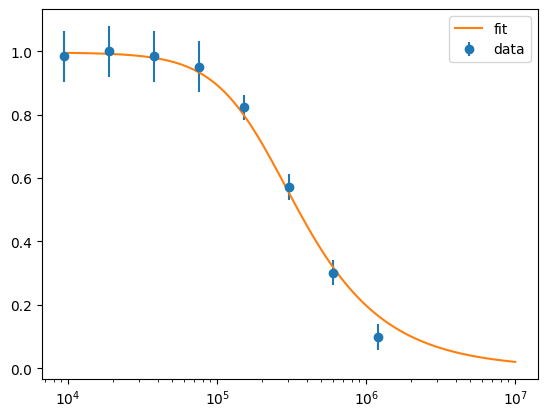

In [20]:
x = np.logspace(4,7,100)
y = mod_HR_f(x,*fit_mod_HR.bval)

plt.errorbar(ω,modHR,yerr=fit_mod_HR.sigmaY,fmt='o',label='data')
plt.plot(x,y,label='fit')
plt.xscale('log')
plt.legend()
plt.plot()

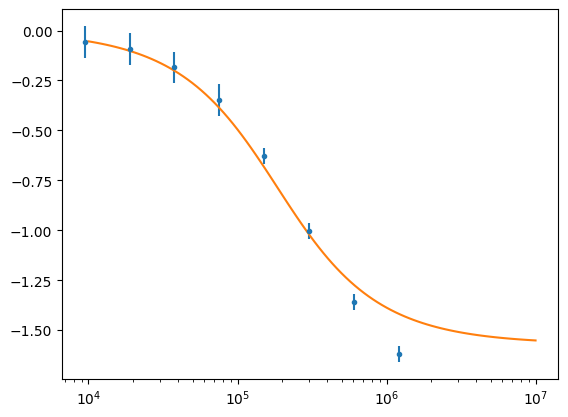

In [22]:
x = np.logspace(4,7,100)
y = arg_HR_f(x,*fit_arg_HR.bval)

plt.errorbar(ω,ΦR,yerr=fit_mod_HR.sigmaY,fmt='.')
plt.plot(x,y)
plt.xscale('log')
plt.show()